# Polscope phase large data processer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import glob
from PIL import Image
import pickle
import os

import waveorder as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


In [19]:
n_media       = 1.512                   # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 63                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 0.9                 # illumination NA of the condenser
N_defocus     = 21                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 0.25               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-N_defocus//2)*z_step
chi           = 0.03*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/'        # data path
bg_path       = '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/BG_2019_0408_1412_1/Pos0/'           # background data path
output_path   = '/mnt/comp_micro/Projects/nucleolus/labelfree_segmentation/phase_recon/'# output image path


In [5]:
# solver option

deconv = 'TV'         # deconvolution method

if deconv == 'Tikhonov':
    reg_u = 1e-1      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-3      # phase regularizer
    
elif deconv == 'TV':
    lambda_u = 1e-2   # absorption regularizer
    lambda_p = 1e-2   # phase regularizer
    rho = 1.5         # rho coefficient of ADMM algorithm (the larger the less noisy and contrast)
    itr = 10          # number of ADMM iteration (10 is usually good)
    verbose = False   # report of the iteration number or not

In [6]:
# Plot setting

max_phase = 2.5                      # maximum phase value to display
min_phase = -1.5                     # minimum phase value to display

max_ret   = 2e-3/lambda_illu*2*np.pi # maximum retardance value
all_z     = False                    # plot all z birefringence or not
z_layer   = 14                        # focal layer to plot if only plot single layer

In [7]:
data_path

'/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/'

In [8]:
filedir = data_path + '*PolState*.tif'
filedir_bg = bg_path + '*.tif'
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

In [9]:
files

['/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/img_000000000_Zyla_PolState0_Widefield_000.tif',
 '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/img_000000000_Zyla_PolState0_Widefield_001.tif',
 '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/img_000000000_Zyla_PolState0_Widefield_002.tif',
 '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/img_000000000_Zyla_PolState0_Widefield_003.tif',
 '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/img_000000000_Zyla_PolState0_Widefield_004.tif',
 '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_

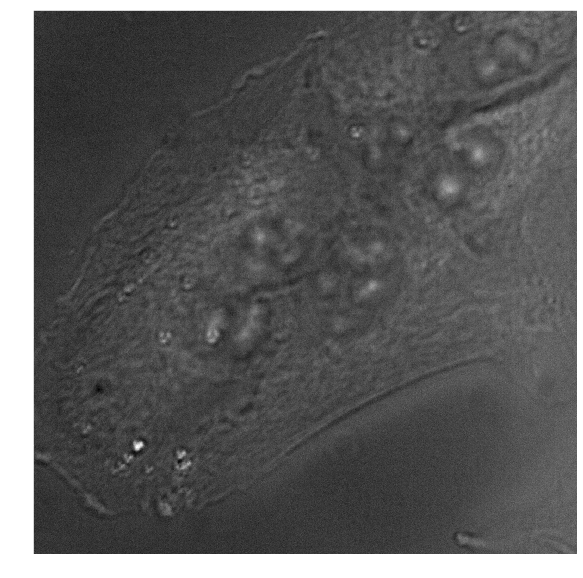

In [10]:
#select a FOV for processing

Ns = 1000
Ms = 1000
n_start = [250, 250] # grating target


plt.figure(figsize=(10,10))
plt.imshow(io.imread(files[0]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms], cmap = 'gray')


In [11]:
%time
setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media=n_media, cali=cali, bg_option=bg_option)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.6 µs


In [17]:
output_path

'/home/andrewchen/ComputationalMicroscopy/Projects/nucleolus/labelfree_segmentation/phase_recon/'

In [21]:
os.system('mkdir '+output_path)
os.system('mkdir '+output_path+'phase')
os.system('mkdir '+output_path+'birefringence')

0

In [22]:
Nimg = N_defocus*N_channel
N_time = len(files)//Nimg
print(Nimg,N_time)

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)
    print("background!")

I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)



for m in range(N_time):
    
    # Load Polscope images
    I_meas_pre =[]

    for i in range(0, Nimg):
        Itemp = io.imread(files[m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
        I_meas_pre.append(Itemp)
        print("Loaded Polscope images!")
    I_meas_pre = np.array(I_meas_pre)
    I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))
    
    # intensity mapping to match the theory
    I_meas = np.zeros_like(I_meas_pre)
    for i in range(N_defocus):
        I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])
        print("Intensity mapping!")
    
    
    # Stokes vector recon with bg correction
    S_image_recon = setup.Stokes_recon(I_meas)
    S_bg_recon = setup.Stokes_recon(I_bg)
    S_image_tm = setup.Stokes_transform(S_image_recon)
    S_bg_tm = setup.Stokes_transform(S_bg_recon)
    S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm)    
    Recon_para = setup.Polarization_recon(S_image_tm)
    
    # Take out S0 for phase reconstruction
    S0_stack = S_image_tm[0].copy()
    
    
    # Phase reconstruction
    
    if deconv == 'Tikhonov':
        mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p)
    
    elif deconv == 'TV':
        mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = lambda_p, \
                                                  itr = itr, rho=rho, verbose = verbose)
    
    
    # figure plotting as tiff files
    
    file_name_phase = output_path+'phase/'+files[m*Nimg].split('State')[0].split('/')[1]+'phase.tiff'
    plt.imsave(file_name_phase, phi_sample, format="tiff", cmap=plt.cm.gray, vmin=min_phase, vmax=max_phase)
    
    if all_z == True:
        for i in range(N_defocus):

            bi_hsv = np.transpose(np.array([Recon_para[1,:,:,i]/np.pi, \
                                               np.ones((Ns,Ms)), \
                                               np.clip(Recon_para[0,:,:,i]/max_ret,0,1)]), (1,2,0))
            bi_rgb = hsv_to_rgb(bi_hsv.copy())


            file_name_bire = output_path+'birefringence/'+files[m*Nimg+i].split('State0')[0].split('/')[1]\
                            +files[m*Nimg+i].split('State0')[1].split('.')[0]+'_birefringence.tiff'
            plt.imsave(file_name_bire, bi_rgb, format="tiff")
            print("saving files!")
    else:
#             bi_hsv = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
#                                                np.ones((Ns,Ms)), \
#                                                np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1)]), (1,2,0))
            norm_phase = np.clip(phi_sample, min_phase, max_phase)-min_phase
            norm_phase /= np.max(norm_phase)
            bi_hsv = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                               np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1), \
                                               norm_phase]), (1,2,0))
            bi_rgb_temp = hsv_to_rgb(bi_hsv.copy())
            bi_rgb = np.zeros_like(bi_rgb_temp)
            bi_rgb[:,:,0] = bi_rgb_temp[:,:,2]
            bi_rgb[:,:,1] = bi_rgb_temp[:,:,1]
            bi_rgb[:,:,2] = bi_rgb_temp[:,:,0]


            file_name_bire = output_path+'birefringence/'+files[m*Nimg+z_layer].split('State0')[0].split('/')[1]\
                            +files[m*Nimg+z_layer].split('State0')[1].split('.')[0]+'_birefringence.tiff'
            plt.imsave(file_name_bire, bi_rgb, format="tiff")


    
    print('Number of image stacks processed (%d / %d)'%(m+1,N_time))

105 1
background!
background!
background!
background!
background!
background!
background!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images!
Loaded Polscope images

ValueError: cannot reshape array of size 7000000 into shape (5,1000000)